In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from train_model import *

# Классификатор открытых/закрытых глаз

С развитием технологий и искусственного интеллекта, необходимость в классификации состояний открытых и закрытых глаз является актуальной задачей. Применение этой технологии может быть широким и разнообразным, от областей, связанных с безопасностью, например, определение уровня сонливости водителя во время длительного вождения, до медицинских исследований, таких как анализ усталости глаз при длительной работе за компьютером.  

В данном проекте был разработан классификатор на основе сверточных нейронных сетей, который обучался на заданной выборке, размеченной в ходы выполения проекта. Удалось обучить классификатор, способный с высокой точностью определять состояние глаз на изображениях.

Было пройденно несколько этапов:

1. [Обзор и подготовка данных](#preprocessing)
2. [Построение модели](#build)
3. [Сохранение модели](#save)
4. [Другие способы](#attempts)
5. [Вывод](#conclusions)

<a id="preprocessing"></a>
# Обзор и подготовка данных

Исходные данные для проекта представляют собой набор из 4000 неразмеченных изображений глаз размером 24x24 пикселя, где глаза могут быть как открытыми, так и закрытыми. Ввиду ограниченного размера выборки и отсутствия начальной разметки, было принято решение вручную разметить эти изображения для обучения классификатора.

Для упрощения процесса разметки был разработан специальный инструмент на языке программирования Python. Этот инструмент был создан с использованием библиотеки Dash, которая представляет собой веб-фреймворк для создания веб-приложений. Использование такого инструмента значительно ускоряет и оптимизирует процесс разметки, делая его более удобным и эффективным.   
https://github.com/molchanov-vs/BinarMarker

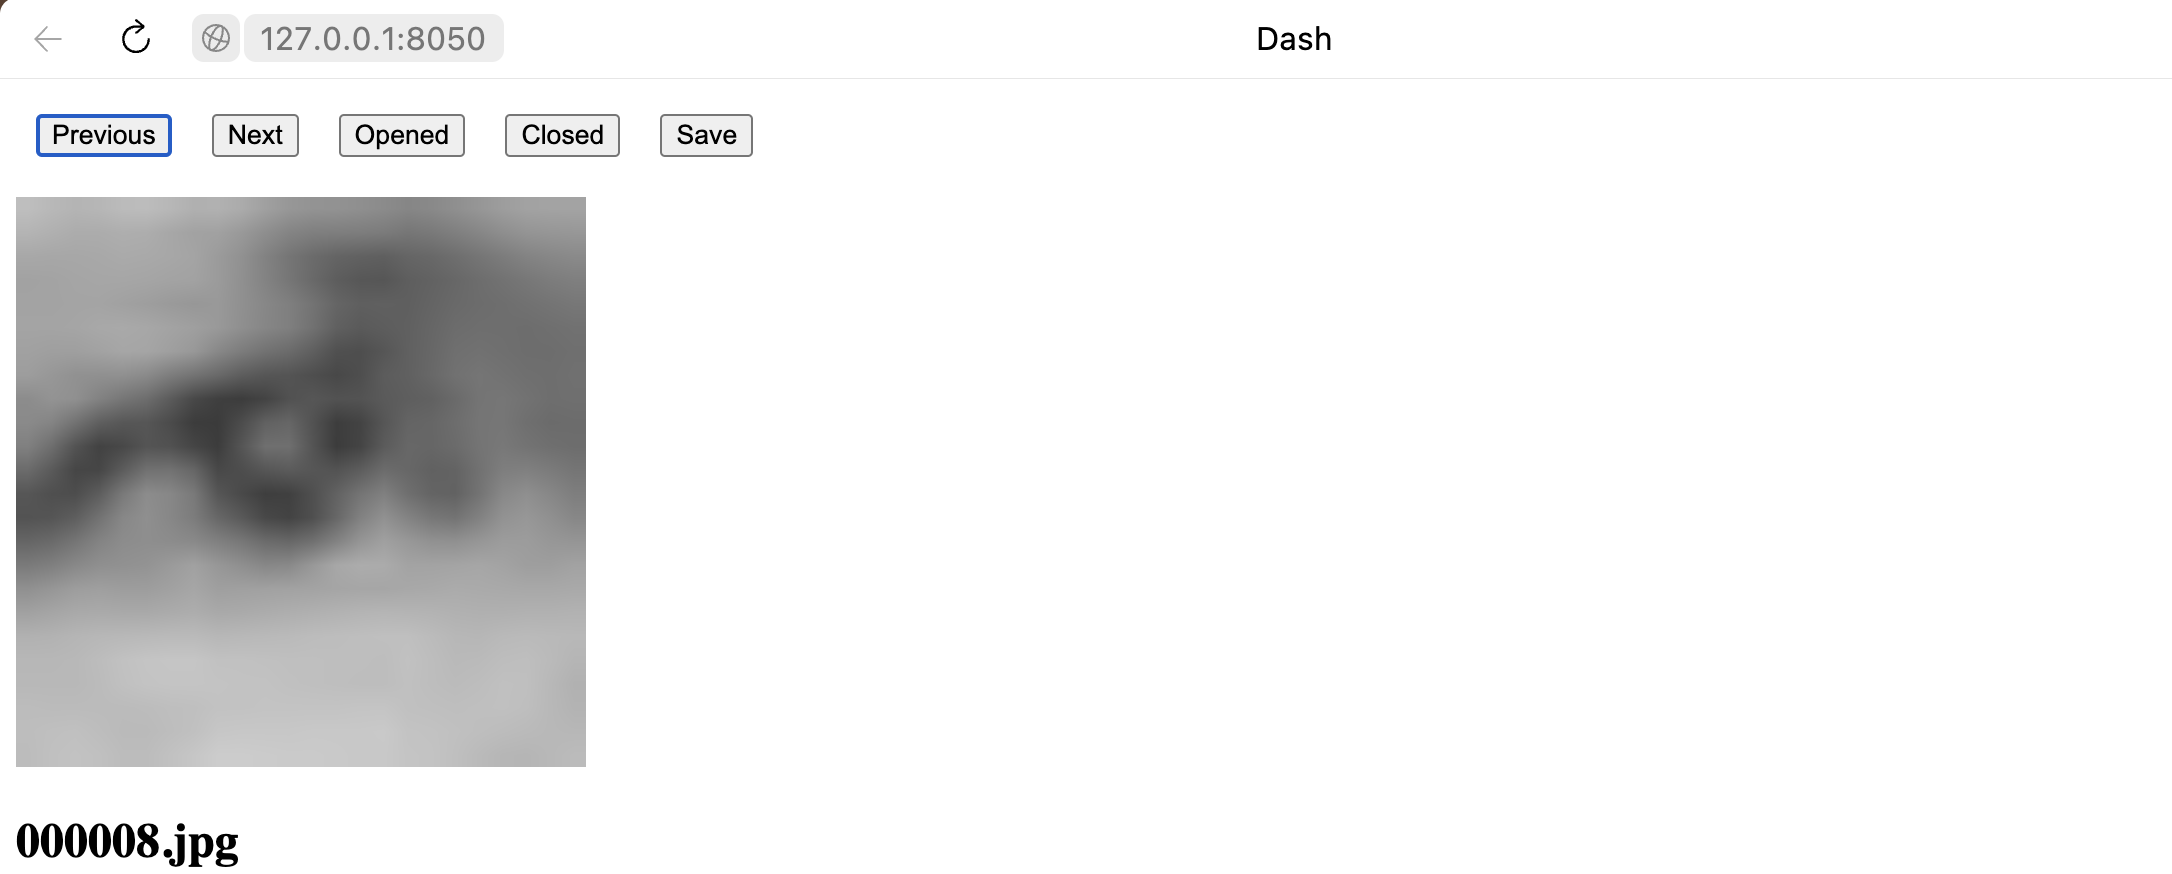

В ходе работы с данными было размечено 2925 изображений, которые получили метки 1 и 0, соответствующие состояниям "открыт" и "закрыт". Остальные изображения остались неразмеченными по причине низкого разрешения, различной освещенности, а также в случаях, когда изображения были полностью неинформативными (например, изображения 000065.jpg, 000549.jpg и др.).

Важно отметить, что в результате ручной разметки данные оказались сбалансированными, что важно для эффективности обучения модели и предотвращения смещения в сторону какого-либо одного класса.

In [2]:
analyze_data('./json/2023-06-25 19:26:22.767659.json')

Labels: 0 1
Counts: 1533 1392


После процесса разметки, готовый набор данных был разделён на две выборки: обучающую (train) и тестовую (test). Для обеспечения достаточного количества данных для обучения и в то же время адекватной оценки производительности модели, было выбрано соотношение 70/30.
```
+---dataset
|   +---test
|       +---closed
|       +---opened
|   +---train
|       +---closed
|       +---opened
```

Следующим шагом стала предварительная обработка (конвертирование в тензор и нормирование) этих изображений:

100%|██████████| 466/466 [00:00<00:00, 15992.42it/s]



Пример размеченных изображений:


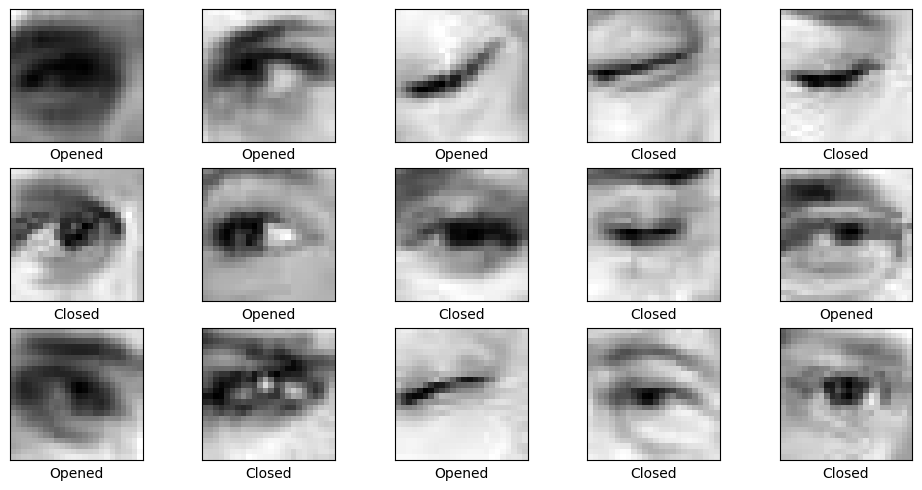

In [3]:
path = '/Users/molchanov/dev/eye_classificator/OpenEyesClassificator/dataset'

train_X, train_Y = load_data(path, 'train')
test_X, test_Y = load_data(path, 'test')

train_X, valid_X, train_label, valid_label = split_train(train_X, train_Y, test_size = 0.2)

show_examples(train_X, train_Y)

<a id="build"></a>
# Построение модели
В данном проекте было решено использовать простую сверточную нейронную сеть, построенную с помощью библиотеки Keras, вместо сложных предобученных моделей из семейств AlexNet, ResNet или VGG. Это решение было принято поскольку задача классификация открытых и закрытых глаз не требует такого большого количества сложности и обучающих параметров, как это может потребоваться для других задач компьютерного зрения.

Архитектура сети выглядит следующим образом:
1. Трех сверточных блоков, каждый из которых включает сверточный слой (32, 64, 128 фильтра), LeakyReLU активацию и MaxPooling.
2. "Flatten" слоя, преобразующего многомерный тензор в одномерный.
3. Полносвязного слоя с 128 нейронами и LeakyReLU активацией.
4. Выходного слоя с одним нейроном для бинарной классификации.

Далее была обучена модель:

Структура модели:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                 

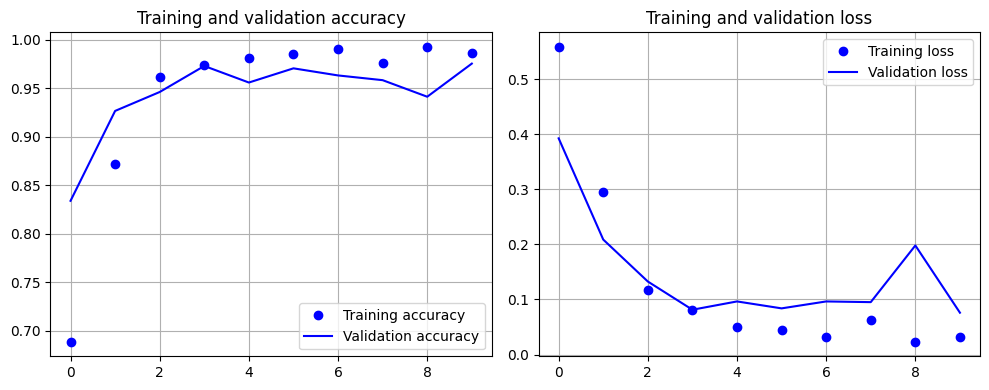

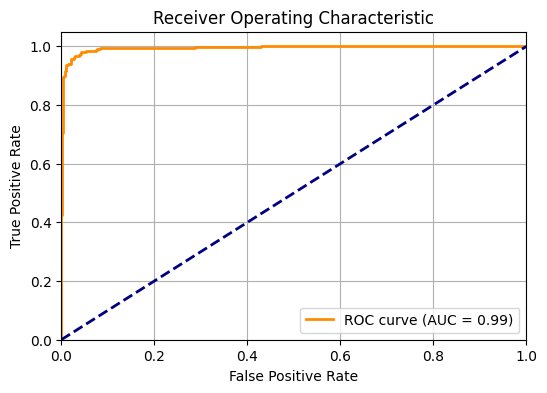

              precision    recall  f1-score   support

      Opened       0.96      0.97      0.97       466
      Closed       0.97      0.96      0.96       412

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878

############
EER: 0.032
############


In [4]:
history, base_model = train_base_model(train_X, train_label, valid_X, valid_label, batch_size=32, epochs=10)
print('Структура модели:')
base_model.summary()
predicted_labels = base_model.predict(test_X)
show_plots(history)
report(test_Y, predicted_labels)

Метрики данной сети удовлетворяют требованиям задания (EER < 0.05). Тем не менее, её можно ещё улучшить добавив слои Dropout:

Структура модели:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 12, 64)        0         
                                    

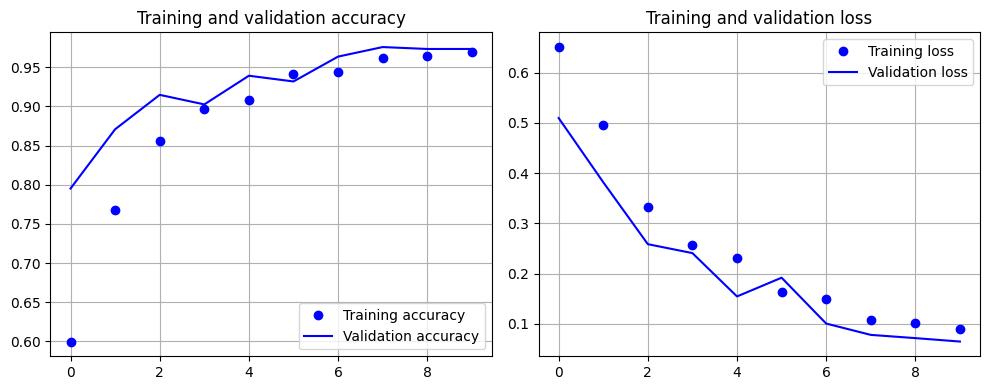

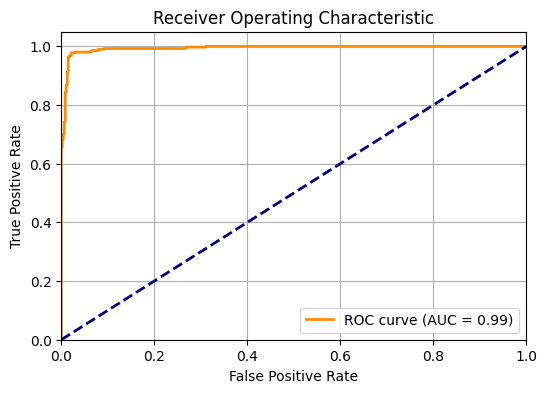

              precision    recall  f1-score   support

      Opened       0.98      0.96      0.97       466
      Closed       0.96      0.98      0.97       412

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878

############
EER: 0.022
############


In [5]:
history, upd_model = train_upd_model(train_X, train_label, valid_X, valid_label, batch_size=32, epochs=10)
print('Структура модели:')
upd_model.summary()
predicted_labels = upd_model.predict(test_X)
show_plots(history)
report(test_Y, predicted_labels)

Результат работы обученной сетки можно посмотреть на следующей подборке "сложных" (средний ряд) и "простых" (первый и третий ряды) изображений.  

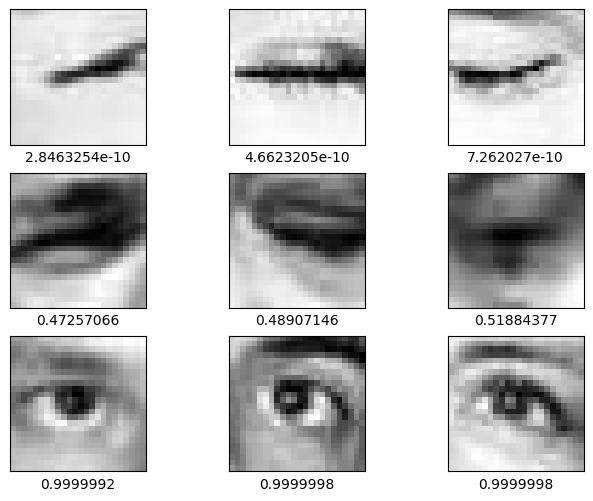

In [6]:
show_examples_of_predicted_images(predicted_labels, test_X)

<a id="save"></a>
# Сохранение модели

In [7]:
upd_model.save('classifier_model.h5')

Далее данную модель можно использовать в виде класса для OpenEyesClassificator
```
from model import OpenEyesClassificator

classifier = OpenEyesClassificator()
prediction = classifier.predict(inpIm)
print(prediction)
```
где inpIm - полный путь к изображению глаза, который возвращает is_open_score - float score классификации от 0.0 до 1.0 (где 1 - открыт, 0 - закрыт).

<a id="attempts"></a>
# Другие способы
В качестве другого способа рассматривался вариант c класстеризацией изображений с помощью библиотеки clustimage:  
https://github.com/erdogant/clustimage

Библиотека clustimage обеспечивает кластеризацию изображений, реализуя многоступенчатую методологию, которая включает тщательную предварительную обработку изображений, выделение ключевых объектов (HOG и PCA) и определение оптимального количества кластеров в пространстве этих объектов.

Этот подход поддерживает использование широко применяемых методов для оценки оптимальности разбиения на кластеры, включая silhouette, dbindex и agglomerative. В дополнение к этому, clustimage предоставляет выбор методов кластеризации, в числе которых agglomerative, kmeans, dbscan и hdbscan, позволяя достичь оптимальной гибкости и эффективности в решении задачи кластеризации изображений.

К сожалению, из-за ограниченности времени не удалось достичь приемлемых результатов.

<a id="conclusion"></a>
# Вывод

Проект по созданию классификатора открытых и закрытых глаз был успешно выполнен с использованием сверточной нейронной сети. Разметка обучающих изображений выполнена вручную, а обученная модель продемонстрировала высокое качество работы, достигнув значения EER = 0.022, что соответствует требованиям проекта. Была рассмотрена возможность применения кластеризации изображений для улучшения результатов, но эта идея требует дальнейшего исследования.